In [3]:
from losses import *
from lr_scheduler import *
from models.vit.vit import *
from partial_fc_v2 import *
from dataset import *
from torch.utils.data import DataLoader
import torchvision.transforms as transfroms

/home/duypham/miniconda3/envs/face-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/duypham/miniconda3/envs/face-env/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
data_src = '/home/duypham/WorkSpace/Generative_Projects/Face_Recognition/datasets/custom_dataset'

In [5]:
train_image_transforms=transfroms.Compose([
    transfroms.RandomHorizontalFlip(),
    transfroms.ToTensor(),
    transfroms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])
image_transforms=transfroms.Compose([
    transfroms.ToTensor(),
    transfroms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

In [6]:
num_class = 1020

In [7]:
train_set=TrainFaceRegDataset(data_src,train_image_transforms,'train',112)
gallery_set=TrainFaceRegDataset(data_src,image_transforms,'gallery',112)
query_set=TrainFaceRegDataset(data_src,image_transforms,'query',112)

In [8]:
train_dataloader=DataLoader(train_set,32,shuffle=True)

In [9]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

backbone = VisionTransformer(embed_dim=768).to(device)
backbone.train()
# margin_loss = CombinedMarginLoss(64,1.0, 0.5, 0.00)
# module_partial_fc = PartialFC_V2(
#             margin_loss, 512, num_class)
# optimizer = torch.optim.AdamW(
#     params=[{"params": model.parameters()}, {"params": module_partial_fc.parameters()}],
#     lr=0.1, weight_decay=5e-4)
# total_iters=len(train_dataloader)*epochs
# lr_scheduler = PolynomialLRWarmup(
#         optimizer=optimizer,
#         warmup_iters=0,
#         total_iters=total_iters)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (mlp): SoftMoe(
        (experts): ModuleList(
          (0-7): 8 x FeedForward(
            (network): Sequential(
              (0): Linear(in_features=768, out_features=3072, bias=True)
              (1): GELU(approximate='none')
              (2): Dropout(p=0.0, inplace=False)
              (3): Linear(in_features=3072, out_features=768

In [10]:
epochs =50
total_iters=len(train_dataloader)*epochs

In [11]:
margin_loss = CombinedMarginLoss(64,1.0, 0.5, 0.00,0)
module_partial_fc = PartialFC_V2(
            margin_loss, 768, num_class,1,True)
module_partial_fc.train().cuda()
optimizer = torch.optim.AdamW(
    params=[{"params": backbone.parameters()}, {"params": module_partial_fc.parameters()}],
    lr=1e-4, weight_decay=0.1)
total_iters=len(train_dataloader)*epochs
lr_scheduler = PolynomialLRWarmup(
        optimizer=optimizer,
        warmup_iters=total_iters//10,
        total_iters=total_iters)

In [12]:
from tqdm import tqdm
from accelerate import Accelerator
def train_loop(epochs, model,module_partial_fc, optimizer, train_dataloader, lr_scheduler,device='cuda'):
    # Initialize accelerator and tensorboard logging
    model.to(device)
    module_partial_fc.to(device)
    accelerator = Accelerator(
        mixed_precision='fp16',
        gradient_accumulation_steps=1,
    )
    model,module_partial_fc, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model,module_partial_fc, optimizer, train_dataloader, lr_scheduler
    )

    global_steps=0
    # Now you train the model
    for epoch in range(epochs):
        progress_bar = tqdm(total=len(train_dataloader))
        progress_bar.set_description(f"Epoch {epoch}")

        module_partial_fc.train()
        model.train()
        for step, (image,label) in enumerate(train_dataloader):
            global_steps+=1
            image = image.to(device)
            label=label.to(device)

            with accelerator.accumulate(model):
                img_emb = model(image)
                loss = module_partial_fc(img_emb, label)
                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_steps}
            progress_bar.set_postfix(**logs)
        # # After each epoch you optionally sample some demo images with evaluate() and save the model
        # if accelerator.is_main_process:
        #     pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

        #     if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
        #         evaluate(config, epoch, pipeline)

        #     if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
        #         if config.push_to_hub:
        #             upload_folder(
        #                 repo_id=repo_id,
        #                 folder_path=config.output_dir,
        #                 commit_message=f"Epoch {epoch}",
        #                 ignore_patterns=["step_*", "epoch_*"],
        #             )
        #         else:
        #             pipeline.save_pretrained(config.output_dir)

In [13]:
# from accelerate import notebook_launcher

# args = (epochs, backbone,module_partial_fc, optimizer, train_dataloader, lr_scheduler,device)

# notebook_launcher(train_loop, args, num_processes=1)

In [14]:
import os

In [15]:
import torch

In [16]:
# torch.save(model.state_dict(), './checkpoints/model2.pt')

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

def visualize_tsne(embeddings, labels, perplexity=30):
    X = np.array(embeddings)
    y = np.array(labels)

    # t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=200)
    X_tsne = tsne.fit_transform(X)

    # Normalize to unit circle
    norms = np.linalg.norm(X_tsne, ord=2, axis=1, keepdims=True)
    X_tsne = X_tsne / norms

    # Convert to DataFrame
    df = pd.DataFrame({
        "x": X_tsne[:, 0],
        "y": X_tsne[:, 1],
        "label": y
    })

    # Plot with seaborn
    plt.figure(figsize=(8, 8))
    sns.scatterplot(
        data=df,
        x="x", y="y",
        hue="label",
        palette="tab20",
        s=10, alpha=0.7,
        linewidth=0
    )
    plt.title("t-SNE visualization of embeddings")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()


In [18]:
import torch.nn.functional as F

In [19]:
embeddings=[]
labels=[]
backbone.to(device)
for image,label in query_set:
    backbone.eval()
    with torch.inference_mode():
        image = image.to(device)
        label=label.to(device).unsqueeze(0)

        embedding= backbone(image.unsqueeze(0))
        embeddings.extend(F.normalize(embedding.detach().cpu(),dim=-1).numpy().tolist())
        labels.extend(label.detach().cpu().numpy().tolist())
        if len(embeddings)>900:
            break

In [20]:
np.array(embeddings).shape

(901, 768)

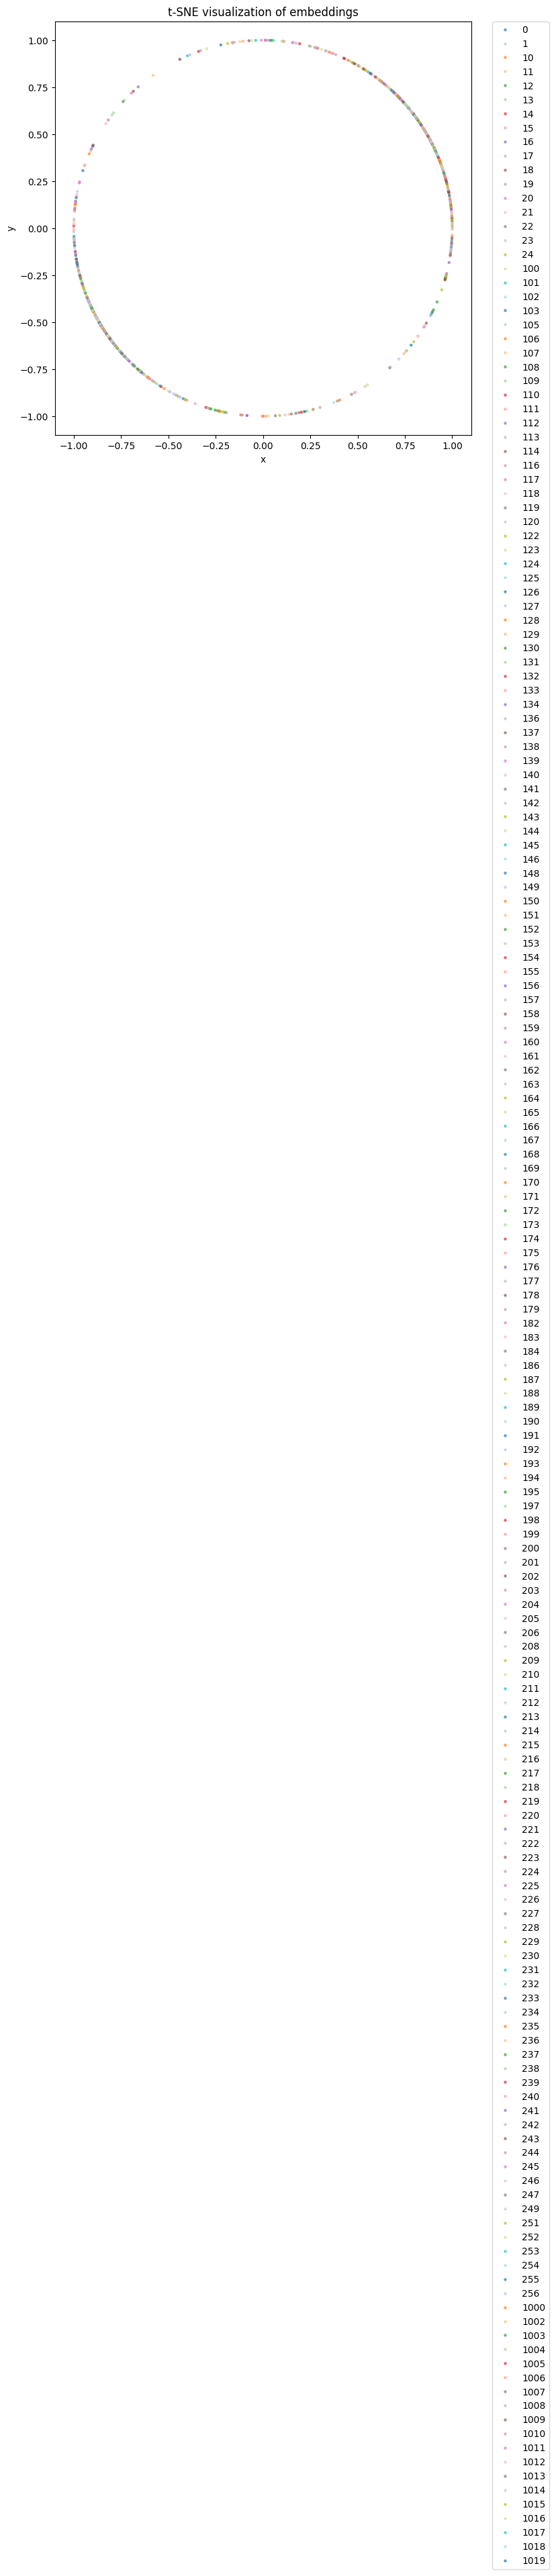

In [21]:
visualize_tsne(embeddings, labels, perplexity=30)